In [1]:
import os
import time
import shutil
import argparse
import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.nn.init as init
from torchvision import datasets

In [2]:
model_num = 2
data_num = 6
point_len = 5
ch_num = 19
time_len =  point_len/10

In [3]:
class Model(nn.Module):
    def __init__(self, loss):
        super(Model, self).__init__()
        input_c = ch_num
        channel = 256
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_c, channel, kernel_size=5, stride=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(channel))
        self.fc1 = nn.Sequential(
            nn.Linear(channel, 10),
            nn.Softmax(dim=1))
        self.loss = loss
        
    def forward(self, data, target):
        x = self.conv1(data)
#         print('1', x.size())
        x = x.view(x.size()[0],-1)
#         print('2', x.size())
        h = self.fc1(x)
#         print('3', h.size())
        
        l = self.loss(h, target)
        return l, h, target

In [4]:
torch.manual_seed(37)
torch.cuda.manual_seed_all(37)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

init_input = torch.randn(10,19,5).to(device)
init_input.requires_grad=True
init_target = torch.zeros((10,10)).to(device)

for k in range(10):
    init_target[k][k]=1
    
learning_rate = 0.005
loss_func=nn.BCELoss()
model = nn.DataParallel(Model(loss_func)).to(device)
optimizer = torch.optim.Adam([init_input], lr=learning_rate)

model.load_state_dict(torch.load('../../../ckpt/model%d/sim_data%d/%dch/%.1f_ckpt_1000.pt'\
                       %(model_num, data_num, ch_num, time_len)))

for param in model.parameters():
    param.requires_grad = False

In [5]:
a = time.time()
loss_list = []
for i in range(5000):
    optimizer.zero_grad()
    loss, output_, target_ = model(init_input, init_target)
    loss = loss.sum()
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.cpu().item())
    
    if i%500==0:
        print('test -  loss : %.7f'%(loss_list[-1]))
        print('shape check :', np.shape(output_), np.shape(target_))
        

/opt/anaconda3/envs/khj/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


test -  loss : 2.0964496
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0017728
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0006921
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0003912
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0002524
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0001739
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0001248
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0000923
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0000714
shape check : torch.Size([10, 10]) torch.Size([10, 10])
test -  loss : 0.0000560
shape check : torch.Size([10, 10]) torch.Size([10, 10])


In [6]:
output_ = output_.cpu().detach().numpy()
target_ = target_.cpu().detach().numpy()
input_ = init_input.cpu().detach().numpy()
print(np.round(output_,3), '\n\n',target_)

print(init_input.size())

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] 

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
torch.Size([10, 19, 5])


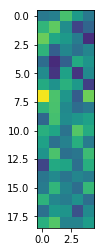

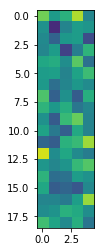

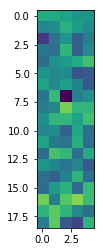

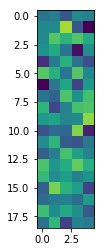

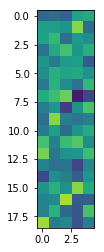

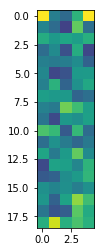

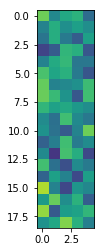

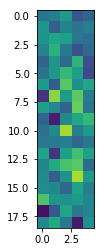

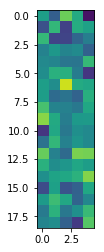

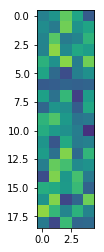

In [8]:
for k in range(10):
    plt.imshow(input_[k], vmin=-3, vmax=3)
    plt.show()